<a href="https://colab.research.google.com/github/hrago/COVID-19-Classification-on-RESNET-50/blob/master/COVID_2_RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from builtins import range, input
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from glob import glob

In [ ]:
covid_dir = "/content/drive/My Drive/Data/COVID"
non_covid_dir = "/content/drive/My Drive/Data/Non-COVID"

In [ ]:
covid = glob(covid_dir + '/*')
noncovid = glob(non_covid_dir + '/*')

In [ ]:
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid)):
  image = cv2.imread(covid[i])  
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image,(224,224)) 
  covid_images.append(image) 
  covid_labels.append('CT_COVID') 
for i in range(len(noncovid)):
  image = cv2.imread(noncovid[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

In [ ]:
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [ ]:
# Split into training and testing sets 
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge covid and non-covid images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Assign labels 0 and 1 
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [ ]:
#  Model
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=resnet.input, outputs=outputs)

for layer in resnet.layers:
    layer.trainable = False

model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

94773248/94765736 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
batch_size = 20
epochs = 100
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/100
48/48 [==============================] - 14s 298ms/step - loss: 1.2381 - accuracy: 0.7219 - val_loss: 1.3758 - val_accuracy: 0.6917
Epoch 2/100
48/48 [==============================] - 15s 303ms/step - loss: 1.1319 - accuracy: 0.7396 - val_loss: 0.5329 - val_accuracy: 0.8292
Epoch 3/100
48/48 [==============================] - 14s 302ms/step - loss: 0.9731 - accuracy: 0.7542 - val_loss: 0.5009 - val_accuracy: 0.8583
Epoch 4/100
48/48 [==============================] - 15s 303ms/step - loss: 1.4370 - accuracy: 0.7177 - val_loss: 0.8699 - val_accuracy: 0.8208
Epoch 5/100
48/48 [==============================] - 15s 304ms/step - loss: 1.2290 - accuracy: 0.7250 - val_loss: 0.6048 - val_accuracy: 0.8417
Epoch 6/100
48/48 [==============================] - 15s 309ms/step - loss: 1.3212 - accuracy: 0.7010 - val_loss: 0.4591 - val_accuracy: 0.8542
Epoch 7/100
48/48 [==============================] - 15s 303ms/step - loss: 1.5355 - accuracy: 0.6917 - val_loss: 2.2974 - val_accuracy:

In [ ]:
# Save Model and Weights
model.save('COVID_RESNET50.h5')
model.save_weights('COVID_WEIGHT_RESNET50.hdf5')

In [ ]:
model = load_model('COVID_RESNET50.h5')

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

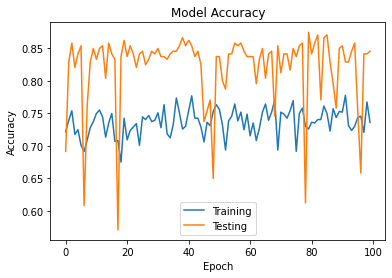

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_accuracy.png')
plt.show()

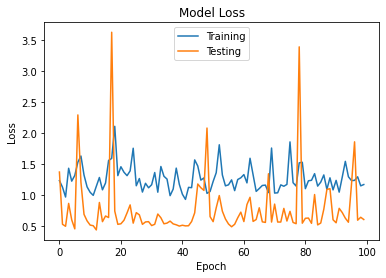

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_loss.png')
plt.show()

In [ ]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

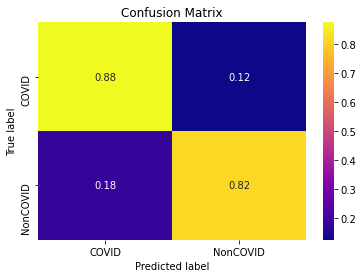

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin,y_pred_bin))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       120
           1       0.87      0.82      0.84       120

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240

